# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe
import cnn_utils

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

We first load the model files and set the top layers' name.

In [5]:
if not os.path.isfile('../models/COCO/GoogleNetCOCO.caffemodel'):
    url = 'http://www.cs.bu.edu/groups/ivc/data/ExcitationBP/COCO/GoogleNetCOCO.caffemodel'
    urllib.urlretrieve(url, '../models/COCO/GoogleNetCOCO.caffemodel')
caffe.set_mode_gpu()
net = caffe.Net('../models/COCO/deploy.prototxt',
                '../models/COCO/GoogleNetCOCO.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../models/COCO/catName.txt')
param = dict()
imgScale = 224
topLayerName = 'loss3/classifier'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = net.top_names[secondTopLayerName][0]

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

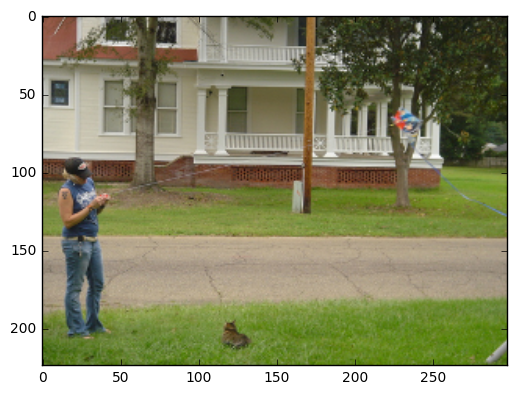

In [6]:
imgName = 'COCO_val2014_000000139781.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [7]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = cnn_utils.imagenet_transformer(net)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = topLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('person', 0.48118794), ('car', 0.24551064), ('bench', 0.052021645), ('truck', 0.035573922), ('dog', 0.027694162), ('chair', 0.022356449), ('fire hydrant', 0.020682586), ('cup', 0.012563072), ('bottle', 0.012223942), ('backpack', 0.011581975)]


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].imshow(attMap, interpolation = 'bicubic')
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax[(i+1)/2, (i+1)%2].set_title(tagName[i])
/home/will/src/Caffe-ExcitationBP/excitationBP/util.py:46: VisibleDeprecationWarning: us

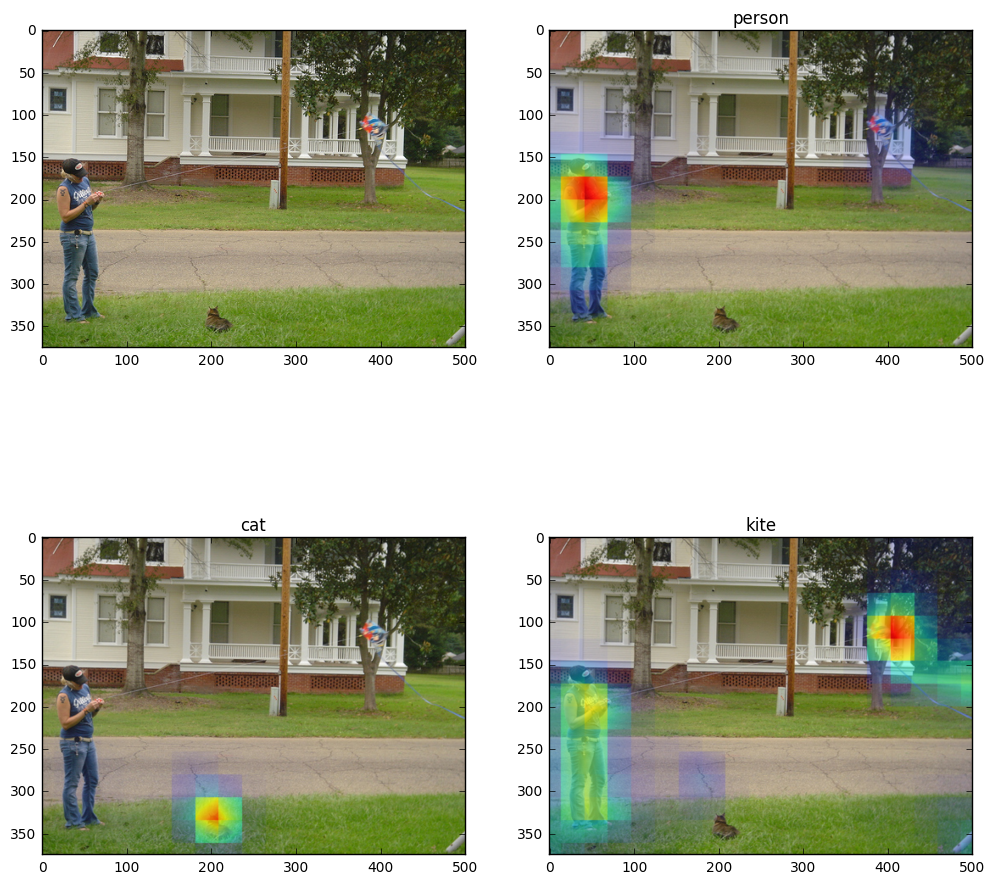

In [9]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['person', 'cat', 'kite']
#specify the output layer name
outputLayerName = 'pool3/3x3_s2'#'inception_5b/output'
outputBlobName = net.top_names[outputLayerName][0] #'inception_5b/output'

excitation_backprop = cnn_utils.ExcitationBackprop(net, 
    topLayerName, secondTopLayerName, outputLayerName,
    top_blob_name=topBlobName, second_top_blob_name=secondTopBlobName,
    output_blob_name=outputBlobName)

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    attMap = excitation_backprop.backprop(tagID)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)
